In [54]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sklearn.datasets

In [55]:
#CONTROL PARAMETERS CELL

name = ["Lagos","Valencia"]

split_size = 0.8
batch_size =  32

hidden_layers =  2
input_size = 2**(hidden_layers+1)
dropout = 0.2
learning_rate = 1e-2

epochs = 200

In [56]:
#samples = 2000
#data, label = sklearn.datasets.make_moons(samples, noise = 0.1)

data = np.load('Dati/dataset_{}_x_{}.npy'.format(name[0],name[1]))
label = np.load('Dati/labels_{}_x_{}.npy'.format(name[0],name[1]))
data = torch.tensor(data, dtype=torch.float32)
label = torch.tensor(label, dtype=torch.float32)
label = torch.reshape(label, [label.shape[0], 1])

print( len(label))

2000


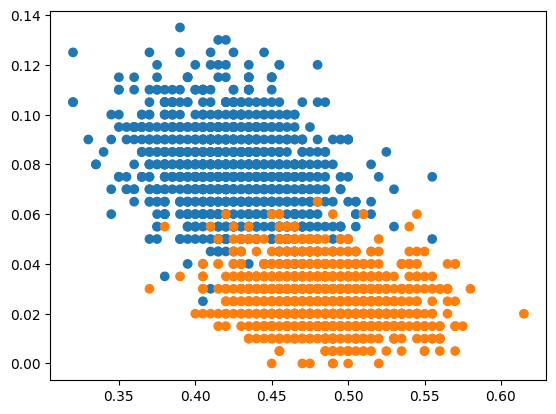

In [57]:
c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in label]  # colours for each class
plt.scatter(data[:, 0], data[:, 1], c=c)
plt.show()

In [58]:
dataset = TensorDataset(data,label)
train_size = int( split_size * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

In [59]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [60]:
class BlockLayer(torch.nn.Module):
    def __init__(self,input_feat, output_feat, d_out = 0):
        super(BlockLayer,self).__init__()
        self.block = torch.nn.Sequential(
            torch.nn.Linear( input_feat, output_feat),
            torch.nn.ReLU(),
            torch.nn.Dropout( d_out )
        )
    def forward(self, x):
        x = self.block(x)
        return x


class ClassicNetwork(torch.nn.Module):
    def __init__(self, hidden_layers, input_feat, d_out):
        super(ClassicNetwork, self).__init__()
        self.layers = torch.nn.ModuleList()

        output_feat = int(input_feat/2)
        self.layers.append( torch.nn.Linear( len(data[0])  , input_feat) )
        self.layers.append(torch.nn.ReLU())
        self.layers.append(torch.nn.Dropout(dropout))

        for i in range (hidden_layers):
            self.layers.append( BlockLayer(input_feat, output_feat, d_out) )
            if output_feat == 1: break
            input_feat = output_feat
            output_feat = int(input_feat*0.8)

        self.layers.append( torch.nn.Linear(input_feat , 1) )
        self.layers.append(torch.nn.Sigmoid())
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
      

In [61]:
model = ClassicNetwork( hidden_layers , input_size, dropout )

In [62]:
opt = torch.optim.Adam( model.parameters(), learning_rate)
lossFunction = torch.nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size= epochs*0.05, gamma=0.9)

In [63]:
def evaluate_model( model , loader , loss_fn  ):
    
    all_outputs = []
    all_labels = []

    # Disabilitare il calcolo dei gradienti per la valutazione
    with torch.no_grad():
        for data, label in loader:
            output = model(data)
            label = torch.reshape(label, [label.shape[0], 1])
            all_outputs.append(output)
            all_labels.append(label)

        # Convertire gli output in tensori per applicare softmax
        all_outputs_tensor = torch.cat(all_outputs)
        all_labels_tensor = torch.cat(all_labels)

        # Calcolare la probabilità con Sigmoid per classificazione
        output_probs = all_outputs_tensor
        predicted = torch.round(output_probs)
    
        # Calcolare l'accuratezza
        #print(  all_outputs_tensor, output_probs , predicted)
        accuracy = accuracy_score(all_labels_tensor.numpy(), predicted.numpy())

        # Calcolare la perdita totale
        #all_outputs_tensor.requires_grad = True  # Re-enable gradients for loss calculation
        loss = lossFunction(all_outputs_tensor, all_labels_tensor).item()

        return accuracy , loss

In [64]:
# This is the actual model training (and validation). It may take a while, depending on:
# epoch number, network architecture, dataset size.

train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)

train_accuracies = np.zeros(epochs)
val_accuracies = np.zeros(epochs)
# training the model
for i in range(epochs):
    training_total_loss = []
    model.train()  # Set the model to training mode
    for id_batch, (data, label) in enumerate(train_loader):
   
        opt.zero_grad(set_to_none=True)
        output = model(data)
        #label = torch.reshape(label, [label.shape[0], 1])
        loss = lossFunction(output, label)
        loss.backward()
        opt.step()
        training_total_loss.append(loss.item())

    model.eval()
    train_accuracies[i] , train_losses[i] = evaluate_model( model , train_loader, lossFunction)
    val_accuracies[i] , val_losses[i] = evaluate_model( model , val_loader, lossFunction)
      
    #scheduler.step()

    print(
        "Epoch: {}\tTraining Loss: {:.4f}\tVal Loss: {:.4f}\tTraining Accuracy: {:.2f}%\tValidation Accuracy: {:.2f}%".format(
            i + 1, train_losses[i], val_losses[i], 100 * train_accuracies[i], 100 * val_accuracies[i]
        )
    )

Epoch: 1	Training Loss: 0.7203	Val Loss: 0.7263	Training Accuracy: 49.75%	Validation Accuracy: 51.00%
Epoch: 2	Training Loss: 0.7191	Val Loss: 0.7250	Training Accuracy: 49.75%	Validation Accuracy: 51.00%
Epoch: 3	Training Loss: 0.7181	Val Loss: 0.7238	Training Accuracy: 49.75%	Validation Accuracy: 51.00%
Epoch: 4	Training Loss: 0.7170	Val Loss: 0.7226	Training Accuracy: 49.75%	Validation Accuracy: 51.00%
Epoch: 5	Training Loss: 0.7160	Val Loss: 0.7215	Training Accuracy: 49.75%	Validation Accuracy: 51.00%
Epoch: 6	Training Loss: 0.7151	Val Loss: 0.7204	Training Accuracy: 49.75%	Validation Accuracy: 51.00%
Epoch: 7	Training Loss: 0.7141	Val Loss: 0.7194	Training Accuracy: 49.75%	Validation Accuracy: 51.00%
Epoch: 8	Training Loss: 0.7133	Val Loss: 0.7184	Training Accuracy: 49.75%	Validation Accuracy: 51.00%
Epoch: 9	Training Loss: 0.7124	Val Loss: 0.7174	Training Accuracy: 49.75%	Validation Accuracy: 51.00%
Epoch: 10	Training Loss: 0.7116	Val Loss: 0.7165	Training Accuracy: 49.75%	Validat

Text(0, 0.5, 'Loss')

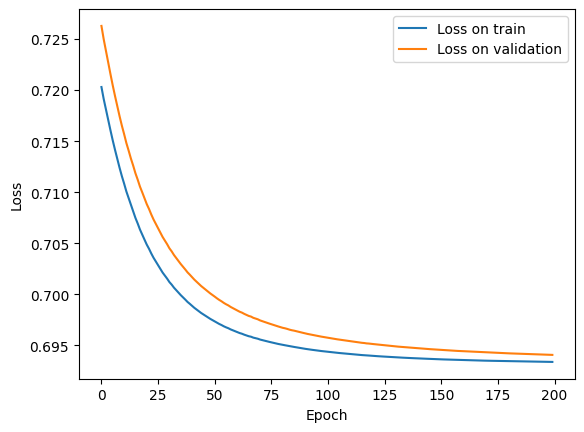

In [65]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Loss on train", "Loss on validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

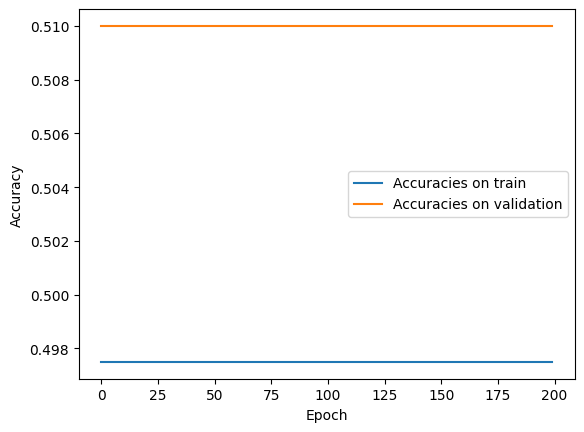

In [66]:
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.legend(["Accuracies on train", "Accuracies on validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")